## APPROACH:
### 1. Loading custom dataset
### 2. NLP pipeline for text preprocessing
### 3. Loading Glove embedding matrix
### 4. Converting sentences to vectors (creating the o/p of embedding layer)
### 5. Creating Keras embedding layer and feeding to biLSTM
### 6. Results visualization and comparison

In [0]:
import re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')

# NLP
from nltk.tokenize.regexp import RegexpTokenizer
#from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# import gensim
import spacy
import en_core_web_sm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve

## Step 1: Load dataset

In [2]:
from google.colab import files
uploaded = files.upload()

Saving emaildataset.csv to emaildataset.csv


In [5]:
# emails_df = pd.read_csv('./emails.csv', nrows=20000)
df = pd.read_csv('./emaildataset.csv')
print(df.shape)
df.head()

(951, 7)


,From,To,Subject,Body,Class,TransactionID,Payment Date
0,Spike@DEUTSCHEBANK.com,Shaniece@CitiBankPune.com,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,Pending,72558,04-02-2020
1,Stacy@HDFC.com,Rohan@CitiBankNewYork.com,Order for new Cheque book,"Good morning, I want to place an order for an ...",General,212096,29-05-2020
2,Zachary@HDFC.com,Rishabh@CitiBankPune.com,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,Processing,847047,26-01-2020
3,Stacy@SBI.com,Shai@CitiBankHongKong.com,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,Request,746078,17-06-2019
4,Angela@HDFC.com,Dipesh@CitiBankSingapore.com,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,Pending,535918,18-02-2020


In [6]:
df.Class.unique()

array(['Pending', 'General', 'Processing', 'Request', 'Complete',
       'Failed'], dtype=object)

In [0]:
nlp_ = en_core_web_sm.load()

In [0]:
nlp = spacy.load('en')

In [0]:
def clean(text):
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = " ".join([i for i in text.lower().split()])
    print(text)
    
    customize_stop_words = ["cc","subject","http", "gbp", "usd", "eur", "inr", "cad","thanks", "acc", "id", "account", "regards", "hi", "hello", "thank you", "greetings"]
    rem_stop = ["not", "wasn't", "hadn't", "won't", "can't", "didn't"]
    
    for w in customize_stop_words:
        nlp.vocab[w].is_stop = True
    
    for w in rem_stop:
        nlp.vocab[w].is_stop = False
    
    doc = nlp(text)
    
    normalized = " ".join(token.lemma_ for token in doc if not token.is_stop)
    
    doc = " ".join(token.orth_ for token in nlp(normalized) if not token.is_punct | token.is_space)

#     exclude = set(string.punctuation) 
#     lemma = WordNetLemmatizer()
#     porter= PorterStemmer()

    # IS AMOUNT EXTRACTION  NEEDED?
    #amount = "".join([i for i in text.lower().split() if i.isdigit()])
    
#     stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
#     punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
#     doc = lemma(punc_free)
    
#     normalized = " ".join(lemma(word) for token in punc_free.split())
#     stem = " ".join(porter.stem(token) for token in normalized.split())
#     return normalized, amount

#     return normalized
    return doc

In [10]:
print(clean("payment in id 1234 for amount 14859 GBP has been freezed"))

payment in id for amount gbp has been freezed
payment would freeze


In [0]:
for i in range(df.shape[0]):
    # merge subject and body strings
    df['Text_Data'] = (df['Subject'] + " " + df['Body'])

In [0]:
def converter(x):
    try:
        return ' '.join([x.lower() for x in str(x).split()])
    except AttributeError:
        return None  # or some other value

df['Text_Data'] = df['Text_Data'].apply(converter)

In [13]:
df.head()

,From,To,Subject,Body,Class,TransactionID,Payment Date,Text_Data
0,Spike@DEUTSCHEBANK.com,Shaniece@CitiBankPune.com,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,Pending,72558,04-02-2020,transaction no. 072558 is unresolved. sorry to...
1,Stacy@HDFC.com,Rohan@CitiBankNewYork.com,Order for new Cheque book,"Good morning, I want to place an order for an ...",General,212096,29-05-2020,"order for new cheque book good morning, i want..."
2,Zachary@HDFC.com,Rishabh@CitiBankPune.com,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,Processing,847047,26-01-2020,required money acquired. transaction 847047 is...
3,Stacy@SBI.com,Shai@CitiBankHongKong.com,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,Request,746078,17-06-2019,asking for the details for transaction 746078 ...
4,Angela@HDFC.com,Dipesh@CitiBankSingapore.com,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,Pending,535918,18-02-2020,partial payment for transaction 535918 hello!!...


In [14]:
# sub_df["content"]=sub_df["content"].map(clean)
text_clean=[]

for i in range(df.shape[0]):
    text_clean.append(clean(df.loc[i]['Text_Data']))

# text_clean
# print(type(df.values[i][7]))

transaction no is unresolved sorry to inform that there has been only a partial payment of amount gbp you are definitely going to receive the rest at a later point of time warm regards
order for new cheque book good morning i want to place an order for an multicity cheque book for account no having atleat leaves kindly send the same to the address mentioned in my account records
required money acquired transaction is in process hello this is to inform you that i have received the amount you transferred to my account and now it is currently in process
asking for the details for transaction i request you to kindly send the status of my transaction with id thanks and regards
partial payment for transaction hello greetings for the day status of transaction usd for account is pending i would be grateful if you could tell me the cause thanks a lot
payment done and transaction settled greetings i wanted to let you know that i have acknowledged the payment for transaction in response to your e

In [0]:
df['Text_Data'] = text_clean

In [16]:
df.head()

,From,To,Subject,Body,Class,TransactionID,Payment Date,Text_Data
0,Spike@DEUTSCHEBANK.com,Shaniece@CitiBankPune.com,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,Pending,72558,04-02-2020,transaction unresolved sorry inform partial pa...
1,Stacy@HDFC.com,Rohan@CitiBankNewYork.com,Order for new Cheque book,"Good morning, I want to place an order for an ...",General,212096,29-05-2020,order new cheque book good morning want place ...
2,Zachary@HDFC.com,Rishabh@CitiBankPune.com,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,Processing,847047,26-01-2020,require money acquire transaction process info...
3,Stacy@SBI.com,Shai@CitiBankHongKong.com,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,Request,746078,17-06-2019,ask detail transaction request kindly send sta...
4,Angela@HDFC.com,Dipesh@CitiBankSingapore.com,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,Pending,535918,18-02-2020,partial payment transaction day status transac...


In [17]:
df['Text_Data'][0]

'transaction unresolved sorry inform partial payment definitely go receive rest later point time warm'

In [18]:
df['Text_Data'][1]

'order new cheque book good morning want place order multicity cheque book have atleat leave kindly send address mention record'

In [19]:
df['Text_Data'][2]

'require money acquire transaction process inform receive transfer currently process'

In [0]:
lengths = []

for i in range(df.shape[0]):
    words = df.values[i][7].split()
    lengths.append(len(words))
    
avg = int(np.mean(lengths) + 2*np.std(lengths))

In [0]:
# df['Subject'][1005] + " " + df['Body'][1005]

## Step 3: Loading word2vec

In [0]:
#convert sentences to embeddings and classes to one-hot vectors

In [23]:
!wget http://nlp.stanford.edu/data/glove.6B.zip 

--2020-06-14 05:06:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-06-14 05:06:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-06-14 05:06:44--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [24]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [25]:
embeddings_index = {}
with open('./glove.6B.300d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:],dtype='float32')
        
#         print(word)
#         print(coeffs)
        embeddings_index[word] = coeffs
    f.close()
print(len(embeddings_index))

# embeddings_index = dict()
# f = open('./glove.6B.300d.txt')
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

400000


In [26]:
print(len(embeddings_index))
print(len(embeddings_index['girl']))

400000
300


## Step 4 - Converting sentences to vectors (creating the o/p of embedding layer)

In [27]:
t = Tokenizer()
l = list(df.Text_Data)
t.fit_on_texts(l)
vocab_size = len(t.word_index) + 1
print(vocab_size)

# integer encode the mails
encoded_mails = t.texts_to_sequences(l)

#post padding
padded_inputs = pad_sequences(encoded_mails, maxlen=avg, padding='post')
# print(padded_inputs)

293


In [28]:
padded_inputs[0]

array([  1, 136, 211,  12,  53,   2,  62, 212,   6,  74, 103, 213, 193,
        44,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [41]:
# create a weight matrix for words in training docs

print(encoded_mails[0])
embedding_matrix_train = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_train[i] = embedding_vector
        # print(i)
        # print(word)
        # print()
embedding_matrix_train.shape    

[1, 136, 211, 12, 53, 2, 62, 212, 6, 74, 103, 213, 193, 44]


(293, 300)

In [0]:
# import preprocessing from sklearn
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder 

In [0]:
le = OneHotEncoder()
classes = df['Class'].values

classes = classes.reshape(-1, 1)
Y = le.fit_transform(classes)

In [0]:
Y = Y.toarray()

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_inputs, Y, test_size=0.2, stratify=Y)

In [0]:
# Y_test.unique()

In [35]:
Y_test.shape

(191, 6)

In [0]:
from keras.utils import to_categorical

YT = to_categorical(Y_train, num_classes=6)
Yt = to_categorical(Y_test, num_classes=6)

In [0]:
# define model
model_glove = Sequential()
model_glove.add(Embedding(vocab_size, 300, weights=[embedding_matrix_train], input_length=avg, trainable=True))
model_glove.add(Bidirectional(LSTM(20,input_shape=(avg,300), return_sequences=True)))
model_glove.add(Dropout(0.2))
model_glove.add(BatchNormalization())

model_glove.add(Bidirectional(LSTM(20, input_shape=(avg,300), return_sequences=False)))
model_glove.add(Dropout(0.2))
model_glove.add(BatchNormalization())

# model_glove.add(Bidirectional(LSTM(20)))
# model_glove.add(Dropout(0.2))
# model_glove.add(BatchNormalization())

# model_glove.add(Dense(64, activation='relu'))
model_glove.add(Dense(64, activation='relu'))

model_glove.add(Dense(6))
model_glove.add(Activation('softmax'))
model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
model_glove.fit(X_train, Y_train, epochs = 10)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
760/760 [==============================] - 3s 4ms/step - loss: 1.0284 - accuracy: 0.6868
Epoch 2/10
760/760 [==============================] - 1s 1ms/step - loss: 0.2647 - accuracy: 0.9842
Epoch 3/10
760/760 [==============================] - 1s 1ms/step - loss: 0.0785 - accuracy: 1.0000
Epoch 4/10
760/760 [==============================] - 1s 1ms/step - loss: 0.0347 - accuracy: 1.0000
Epoch 5/10
760/760 [==============================] - 1s 1ms/step - loss: 0.0262 - accuracy: 1.0000
Epoch 6/10
760/760 [==============================] - 1s 1ms/step - loss: 0.0169 - accuracy: 1.0000
Epoch 7/10
760/760 [==============================] - 1s 1ms/step - loss: 0.0130 - accuracy: 1.0000
Epoch 8/10
760/760 [==============================] - 1s 1ms/step - loss: 0.0097 - accuracy: 1.0000
Epoch 9/10
760/760 [==============================] - 1s 1ms/step - loss: 0.0078 - accuracy: 1.0000
Epoch 10/10
760/760 [==============================] - 1s 1ms/step - loss: 0.0071 - accuracy: 1.0000

In [45]:
y_pred = model_glove.predict(X_test)
y_pred

array([[3.0994210e-03, 7.2051608e-03, 1.3022632e-02, 9.6041054e-01,
        1.3562061e-02, 2.7002546e-03],
       [8.3828960e-03, 2.0953920e-02, 1.0703345e-02, 9.2691237e-01,
        2.7028041e-02, 6.0194260e-03],
       [5.6990283e-03, 8.0372365e-03, 3.5592390e-03, 4.1039460e-03,
        9.7623563e-01, 2.3649856e-03],
       ...,
       [1.4455767e-03, 9.9181503e-01, 6.3984829e-04, 2.0771280e-03,
        2.8701732e-03, 1.1522587e-03],
       [1.9291844e-03, 9.0636790e-04, 9.8864949e-01, 2.8995224e-03,
        2.7951931e-03, 2.8202799e-03],
       [3.0921937e-03, 6.9134920e-03, 4.3329839e-03, 9.7526509e-01,
        9.1370698e-03, 1.2591911e-03]], dtype=float32)

In [46]:
le.inverse_transform(y_pred)

array([['Pending'],
       ['Pending'],
       ['Processing'],
       ['Request'],
       ['Request'],
       ['Pending'],
       ['Processing'],
       ['Pending'],
       ['General'],
       ['Request'],
       ['Failed'],
       ['Request'],
       ['Complete'],
       ['Processing'],
       ['Failed'],
       ['General'],
       ['Failed'],
       ['Pending'],
       ['Processing'],
       ['Request'],
       ['Pending'],
       ['Failed'],
       ['Failed'],
       ['Complete'],
       ['Pending'],
       ['Processing'],
       ['Processing'],
       ['Request'],
       ['Failed'],
       ['Pending'],
       ['Request'],
       ['General'],
       ['Request'],
       ['Pending'],
       ['Failed'],
       ['Request'],
       ['General'],
       ['Processing'],
       ['Request'],
       ['Failed'],
       ['Pending'],
       ['Failed'],
       ['Complete'],
       ['Failed'],
       ['General'],
       ['General'],
       ['General'],
       ['Failed'],
       ['Complete'],
      

In [47]:
model_glove.evaluate(X_test,Y_test)

191/191 [==============================] - 0s 1ms/step


[0.035217310219066926, 1.0]

In [48]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


#our model starts to overfit after a certain point. We can save the model upto the point where we get max valdn acc
#done using callback
checkpt = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=True, save_best_only=True)
earlystop = EarlyStopping(monitor='val_acc', patience=10)


hist = model_glove.fit(X_train,Y_train,batch_size=32,epochs=10,shuffle=True,validation_split=0.2, callbacks=[checkpt, earlystop])
# consider params --> model.fit(X_train,YT,validation_split=0.2,epochs=10,batch_size=128)

Train on 608 samples, validate on 152 samples
Epoch 1/10
608/608 [==============================] - 1s 1ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0194 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.01939, saving model to best_model.h5
Epoch 2/10
 96/608 [===>..........................] - ETA: 0s - loss: 0.0082 - accuracy: 1.0000

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


608/608 [==============================] - 1s 1ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.01939 to 0.01185, saving model to best_model.h5
Epoch 3/10
608/608 [==============================] - 1s 1ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.01185 to 0.00751, saving model to best_model.h5
Epoch 4/10
608/608 [==============================] - 1s 1ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.00751 to 0.00485, saving model to best_model.h5
Epoch 5/10
608/608 [==============================] - 1s 1ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000

Epoch 00005: val_loss improved from 0.00485 to 0.00324, saving model to best_model.h5
Epoch 6/10
608/608 [==============================] - 1s 1ms/step - loss: 0.0035 - accuracy: 1.

## Visualise our results

In [0]:
import matplotlib.pyplot as plt

In [0]:
h = hist.history

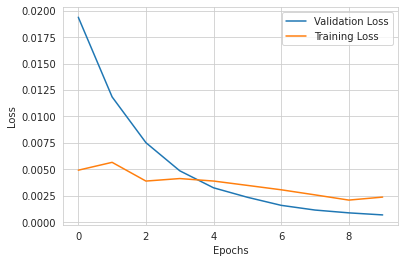

In [51]:
plt.plot(h['val_loss'],label="Validation Loss")
plt.plot(h['loss'],label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

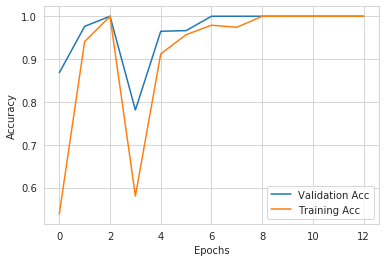

In [0]:
plt.plot(h['val_acc'],label="Validation Acc")
plt.plot(h['acc'],label="Training Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()